# [Exp13]Movie Recommendation

## 데이터 설명

* Movielens 1M Dataset
* 별점 데이터는 대표적인 explicit(명백한) 데이터이지만 implicit(암묵적) 데이터로 간주하고 테스트 가능.
* 별점을 시청횟수로 해석.
* 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외.

## 라이브러리 불러오고 버전 확인하기

In [1]:
import numpy as np
import pandas as pd
import scipy
import implicit
import matplotlib.pyplot as plt

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.23.2
1.8.1
0.6.0


## 데이터 준비와 전처리

* Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.
* [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) 를 통해 데이터를 불러옵니다.
* [Encoding 종류](https://docs.python.org/3/library/codecs.html#standard-encodings)

In [2]:
import os

rating_file_path= 'data/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
print('orginal_data_size =', orginal_data_size)
ratings.head()

orginal_data_size = 1000209


,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
print('User 수 :', ratings['user_id'].nunique())
print('User가 좋아한 서로 다른 영화 수:', ratings['movie_id'].nunique())

User 수 : 6040
User가 좋아한 서로 다른 영화 수: 3706


* ratings 데이터프레임은 유저 ID, 해당 유저가 좋아하는 영화 ID, 평점, 타임스탬프로 이루어져있습니다.
* 위 데이터 설명에서 명시한대로 3점 이상의 데이터만 남깁니다.

In [4]:
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


* 위의 데이터 설명에서 별점을 시청 횟수로 본다고 하였기에 ratings 컬럼의 이름을 counts로 바꿉니다.
* [pandas.DataFrame.rename](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) 을 통해 열 이름을 바꿔줍니다.

In [5]:
display(ratings.head(1))
ratings.rename(columns={'ratings':'counts'}, inplace=True)
display(ratings.head(1))

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760


,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760


In [6]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

* 영화 제목을 보기 위해 메타 데이터(movies.dat)를 읽어옵니다.
* 위의 평점데이터와 동일한 방법으로 불러옵니다.

In [7]:
movie_file_path= 'data/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


* movie 데이터 프레임은 영화 ID, 영화 이름, 영화 장르로 구성되어 있습니다.
* 전처리는 여기까지입니다. 이제 모델을 구성해봅시다.

## 데이터 탐색

* ratings에 있는 유저 수와 유저가 언급한 영화 수를 알아봅시다.
* movie에 있는 전체 영화의 수 또한 알아봅니다.

In [8]:
print('User 수 :', ratings['user_id'].nunique())
print('User가 좋아한 서로 다른 영화 수:', ratings['movie_id'].nunique())
print('메타데이터에 있는 영화 수:', len(movies))

User 수 : 6039
User가 좋아한 서로 다른 영화 수: 3628
메타데이터에 있는 영화 수: 3883


* 선택받지 못한 아쉬운 영화도 있네요.
* movie 데이터프레임에는 장르 또한 있었죠? 장르 개수를 알아봅시다.

In [9]:
print('장르 개수 :', movies['genre'].nunique())
genre_count = movies.groupby('genre')['movie_id'].count()
genre_count.sort_values(ascending=False).head(10)

장르 개수 : 301


genre
Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: movie_id, dtype: int64

* 그럼 가장 인기있는 영화는 무엇일까요?
* 선호하는 사람이 가장 많은 영화일까요?

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

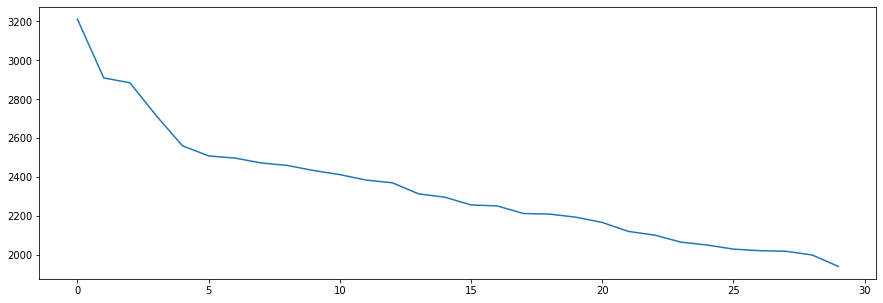

In [10]:
popular = ratings.groupby('movie_id')['user_id'].count()
popular = popular.sort_values(ascending=False).head(30)
display(popular)
plt.figure(figsize=(15,5))
plt.plot(popular.values)

* movie_id인 숫자로 나오니 무슨 영화인지 확인이 어렵습니다.
* 영화 이름도 알아내기 위해서 movies 를 ratings와 병합한 데이터를 사용해서 다시 알아봅시다.

In [11]:
ratings_movie = pd.merge(ratings, movies)
print(len(ratings), len(movies), len(ratings_movie))
ratings_movie

836478 3883 836478


,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836473,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,958346883,Slaughterhouse (1987),Horror
836475,5854,690,3,957744257,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,957273353,"Five Wives, Three Secretaries and Me (1998)",Documentary


In [12]:
popular_name = ratings_movie.groupby('title')['movie_id'].count()
popular_name = popular_name.sort_values(ascending=False).head(30)
display(popular_name)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

## 선호 영화 추가

좀 더 쉽게 알아보기 위해
* movie_id를 넣으면 title을 반환하는 함수
* title을 넣으면 movie_id를 반환하는 함수를 만듭니다.

In [13]:
def id_to_title(id):
    get = movies.index[movies.movie_id == id].tolist()
    return movies.title[get[0]]

def title_to_id(title):
    get = movies.index[movies.title == title].tolist()
    return movies.movie_id[get[0]]

### ratings 데이터 프레임 분석

In [14]:
display(ratings.head())

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


* ratings 는
* user_id : 유저의 id - 숫자 값
* movie_id : 영화의 id - 숫자 값
* counts : 본 횟수(평점) - 숫자 값
* timestamp : 타임스탬프 - 숫자값
* 으로 이루어져 있습니다. 한개씩 알아보겠습니다.
* 먼저 movie_id 입니다.

### movie_id

* 영화 5개를 추가합니다.(title)
1. Terminator, The (1984)
2. Terminator 2: Judgment Day (1991)
3. Saving Private Ryan (1998)
4. Godfather, The (1972)
5. Jurassic Park (1993)
* movie_id를 추가해야 하므로 movies 데이터프레임에서 해당 타이틀에 해당하는 id를 가져옵니다.

In [15]:
# display(movies[movies.title == 'Terminator, The (1984)'])
# display(movies[movies.title == 'Terminator 2: Judgment Day (1991)'])
# display(movies[movies.title == 'Jurassic Park (1993)'])
# display(movies[movies.title == 'Saving Private Ryan (1998)'])
# display(movies[movies.title == 'Godfather, The (1972)'])
my_movies = ['Terminator, The (1984)', 'Terminator 2: Judgment Day (1991)', 'Jurassic Park (1993)','Saving Private Ryan (1998)','Godfather, The (1972)']

[title_to_id(i) for i in my_movies]

[1240, 589, 480, 2028, 858]

* movie_id는 1240, 589, 480, 2028, 858 입니다.
* movie_id는 나왔으니 다음은 user_id 입니다.
* 마지막을 알기 쉽게 ratings의 뒷부분을 출력해볼까요

In [16]:
ratings.tail()

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


* user_id의 마지막이 6040이니 user_id는 6041으로 추가해보겠습니다.
* 그전에 6041의 user_id가 있는지부터 확인해보겠습니다.

In [17]:
ratings[ratings.user_id == 6041]

,user_id,movie_id,counts,timestamp


* 역시 없습니다.
* counts는 임의로 넣는다고 보고 timestamp가 남았습니다. 한번 확인해봅시다.

0          978300760
1          978302109
2          978301968
3          978300275
4          978824291
             ...    
1000203    956715518
1000205    956704887
1000206    956704746
1000207    956715648
1000208    956715569
Name: timestamp, Length: 836478, dtype: int64


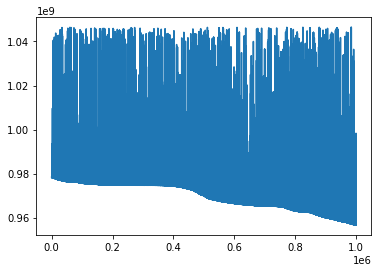

In [18]:
print(ratings.timestamp)
plt.plot(ratings.timestamp)

In [19]:
display(ratings.timestamp.duplicated())
ratings[ratings.timestamp == 956715569]

0          False
1          False
2          False
3          False
4          False
           ...  
1000203     True
1000205     True
1000206     True
1000207    False
1000208     True
Name: timestamp, Length: 836478, dtype: bool

,user_id,movie_id,counts,timestamp
999947,6040,1150,5,956715569
999954,6040,1185,5,956715569
999986,6040,3521,5,956715569
1000008,6040,1962,3,956715569
1000184,6040,2791,4,956715569
1000208,6040,1097,4,956715569


* 같은 유저에서는 중복되는 값이 나와도 상관 없는 것 같으니 임의의 값을 넣되 다른 유저가 가지고 있지 않는 값을 넣습니다.
* 저는 956800000를 넣겠습니다.

In [20]:
ratings[ratings.timestamp == 956800000]

,user_id,movie_id,counts,timestamp


* 다행히 없습니다.
* 그럼 user_id  = 6041
* movie_id 는 1240, 589, 480, 2028, 858
* 평점은 5, 5, 5, 4,4
* timestamp는 956800000로 주겠습니다.

In [21]:
display(ratings.tail(5))
my_favorite = [1240, 589, 480, 2028, 858]
my_counts = [5,5,5,4,4]
my_movielist = pd.DataFrame({'user_id': [6041]*5, 'movie_id' : my_favorite, 'counts' : my_counts, 'timestamp' : [956800000]*5})

if not ratings.isin({'user_id':[6041]})['user_id'].any():
    ratings_edit = pd.concat([ratings, my_movielist]) 

ratings_edit.tail(10)

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,6041,1240,5,956800000
1,6041,589,5,956800000
2,6041,480,5,956800000
3,6041,2028,4,956800000
4,6041,858,4,956800000


* 다행히 잘들어 갔습니다.
* 혹시 모르니 null 값이 있는지 확인해봅시다.

In [22]:
ratings_edit.isnull().any()

user_id      False
movie_id     False
counts       False
timestamp    False
dtype: bool

* null 값이 없으니 계속 진행하겠습니다.

## CSR matrix 생성하기

* 마지막에 추가해준 ID 6041이 사실 6040번째 ID 였군요

In [23]:
num_user = ratings_edit['user_id'].nunique()
num_movie = ratings_edit['movie_id'].nunique()
user_unique = ratings_edit['user_id'].unique()
movie_unique = ratings_edit['movie_id'].unique()
print(num_user, num_movie)
print(user_unique, movie_unique)

6040 3628
[   1    2    3 ... 6039 6040 6041] [1193  661  914 ...  690 2909 1360]


In [24]:
from scipy.sparse import csr_matrix

# csr_data = csr_matrix((ratings_edit.counts, (ratings_edit.user_id, ratings_edit.movie_id)), shape= (num_user, num_movie))

* 단순히 크기만 넣으면 error가 뜹니다. 왜냐하면 최대값이 갯수를 넘어가버리니 때문입니다.
* 이를 해결하기위해서는 id 를 index로 바꿔주는 작업을 하거나 max 값을 구한뒤 shape에 1을 추가해서 넣어주면 됩니다.
* index 변경은 이미 해보았으니 max값을 찾아서 넣어보겠습니다.

In [25]:
max_user = ratings_edit.user_id.max()
max_movie = ratings_edit.movie_id.max()
print(max_user)
print(max_movie)

csr_data = csr_matrix((ratings_edit.counts, (ratings_edit.user_id, ratings_edit.movie_id)), shape= (max_user+1, max_movie+1))
csr_data

6041
3952


<6042x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## als_model을 직접 구성하여 훈련시켜 봅시다.

In [26]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [27]:
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [28]:
als_model.fit(csr_data)

  0%|          | 0/15 [00:00<?, ?it/s]

In [29]:
als_model

## 나의 선호도를 파악

* 내가 선호한 5가지 중 하나인 'Terminator, The (1984)'
* 그 외의 영화 'Bear, The (1988)' 도 넣어봅시다.

In [30]:
# display(movies[movies.title == 'Terminator, The (1984)'])
# display(movies[movies.title == 'Bear, The (1988)'])

print(title_to_id('Terminator, The (1984)'))
print(title_to_id('Bear, The (1988)'))

1240
3412


* 해당 id가 그 영화가 맞는지 재확인 해봅시다.

In [31]:
print(id_to_title(1240))
print(id_to_title(3412))

Terminator, The (1984)
Bear, The (1988)


In [32]:
# 6041이 본인이고 1240, 3412가 영화 id입니다.
my_vector_1, movie_vector_1 = als_model.user_factors[6041], als_model.item_factors[1240]
my_vector_2, movie_vector_2 = als_model.user_factors[6041], als_model.item_factors[3412]

In [33]:
print(np.dot(my_vector_1, movie_vector_1))
print(np.dot(my_vector_2, movie_vector_2))

0.4534663
0.010846814


* 음 5개의 영화가 아닌 다른 값을 넣었을 때 확실히 값이 떨어졌습니다.

## 비슷한 영화 추천받기

* 터미네이터와 비슷한 영화를 추천받아 봅시다.

In [34]:
favorite_movie = 1240

similar_movies, similar_moives_percent = als_model.similar_items(favorite_movie, N=15)

# print(similar_movies)
# print(similar_moives_percent)
tuple_similar_movie = [(similar_movies[i], similar_moives_percent[i]) for i in range(15)]
[id_to_title(i) for i, _ in tuple_similar_movie]

['Terminator, The (1984)',
 'Aliens (1986)',
 'Die Hard (1988)',
 'Predator (1987)',
 'Alien (1979)',
 'Terminator 2: Judgment Day (1991)',
 'Matrix, The (1999)',
 'Blade Runner (1982)',
 'Robocop (1987)',
 'Total Recall (1990)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Indiana Jones and the Last Crusade (1989)',
 'Mad Max 2 (a.k.a. The Road Warrior) (1981)',
 'Raiders of the Lost Ark (1981)',
 'Star Wars: Episode IV - A New Hope (1977)']

## 내가 좋아할만한 영화를 추천받아봅시다.

In [35]:
user = 6041
movie_recommended, movie_recommended_percent = als_model.recommend(user, csr_data[user], N=15, filter_already_liked_items=True)
tuple_movie_recommended = [(movie_recommended[i], movie_recommended_percent[i]) for i in range(15)]
tuple_movie_recommended

[(1221, 0.57344514),
 (110, 0.5359683),
 (2571, 0.5281328),
 (1580, 0.47697157),
 (2916, 0.43403155),
 (260, 0.34236354),
 (1214, 0.33521286),
 (457, 0.32294846),
 (527, 0.3100329),
 (1200, 0.29353482),
 (1196, 0.2880073),
 (1210, 0.2760389),
 (1036, 0.26546094),
 (1198, 0.262715),
 (1387, 0.236408)]

In [36]:
[id_to_title(i) for i, _ in tuple_movie_recommended]

['Godfather: Part II, The (1974)',
 'Braveheart (1995)',
 'Matrix, The (1999)',
 'Men in Black (1997)',
 'Total Recall (1990)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Alien (1979)',
 'Fugitive, The (1993)',
 "Schindler's List (1993)",
 'Aliens (1986)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Die Hard (1988)',
 'Raiders of the Lost Ark (1981)',
 'Jaws (1975)']

* 확실히 추천받은 영화들이 제 취향과 맞는 것 같습니다.
* 가장 높게 추천된 영화에 기여한 영화들을 확인합니다.

In [37]:
explain = als_model.explain(user, csr_data, itemid=1221)
[(id_to_title(i), j) for i, j in explain[1]]

[('Godfather, The (1972)', 0.5299532817566863),
 ('Saving Private Ryan (1998)', 0.04129403184916655),
 ('Terminator, The (1984)', 0.013320360890021296),
 ('Terminator 2: Judgment Day (1991)', -0.0059995309872289335),
 ('Jurassic Park (1993)', -0.013481116440375977)]

* Godfather, Saving Private Ryan 등이 추천을 많이 하였습니다.

## 회고

* 이번 프로젝트에서 어려웠던 점
    - id-movie name을 번갈아가는게 어려웠습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - csr_matrix를 다양한 방법으로 만들 수 있게 특정 방법에 따라 조건이 붙는걸 알았습니다.
  * 아직 모호한 점
    - 가끔 어떤 영화들이 기존에 추천한 영화보다 더 높게 점수를 주는 것을 알았습니다. 그럴 수도 있다고는 생각이 듭니다.
* 루브릭 평가를 맞추기 위해 시도한 점
    - crs_matrix의 생성방법에 대해 document로 공부해보았습니다.
    - 내적 수치를 직접 비교해보았습니다.
    - 추천하는 영화들과 추천된 영화에 기여된 영화들 또한 살펴보았습니다.